### the testing notebook

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import re

In [2]:
def detsec_data(hdu):
    ds = []
    for i in range(1, 9):
        det = hdu['DETSEC0' + str(i)]
        det = det.strip('[]')
        xs, ys = det.split(',')
        x1, x2 = xs.split(':')
        y1, y2 = ys.split(':')
        detsec = [x1, x2, y1, y2]
        ds.append(detsec)
    return np.array(ds, dtype=np.int64)

In [3]:
hdul = fits.open('DE.20210602.22392.fits', ignore_missing_end = True)

In [4]:
hdr0 = hdul[0].header

##

In [5]:
int(hdul[1].header['CCDLOC'])

1

In [6]:
int(hdul[1].header['CCDLOC']) - 1 # actual placement of where the corrected data should go
                                    # array would be 0 - 7 rather than 1 - 8

0

In [52]:
current = np.random.randint(1,9)
print('Current CCD:', current)

Current CCD: 3


In [53]:
ext = np.arange(1,9)

In [54]:
_arr = np.zeros((8,1))

In [55]:
for e in ext:
    if current == e:
        if True:
            print('Numbers match:', current, ',', e)
            _arr[e-1] = np.random.randint(1,100)
        else:
            print('No mo')
print(_arr)

Numbers match: 3 , 3
[[0.]
 [0.]
 [4.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


##

In [7]:
# alldata = []

In [8]:
# _deimos = deimos[1].header

In [9]:
# _data = np.random.rand(1,3)

In [10]:
# alldata.append(_data)
# alldata

##

In [11]:
ext = np.arange(1, 9)

In [12]:
images = hdul[1:9]
# for img in images:
#     plt.imshow(images[img].data, norm = LogNorm())
#     plt.show()

In [13]:
print('Length of each det img:', len(images[6].data))
print('Width of each det img:', len(images[6].data[0])) # larger than what given in detsec
                                                         # x detsec : 2048
                                                         # excess is the overscan region

Length of each det img: 4096
Width of each det img: 2140


In [15]:
r0 = np.concatenate((hdul[1].data, hdul[2].data, hdul[3].data, hdul[4].data), axis=1)
r0 = np.flipud(r0)

# plt.imshow(r0, norm=LogNorm())
# plt.show()

In [16]:
chip5 = np.fliplr(hdul[5].data)
chip6 = np.fliplr(hdul[6].data)
chip7 = np.fliplr(hdul[7].data)
chip8 = np.fliplr(hdul[8].data)

r1 = np.concatenate((chip5, chip6, chip7, chip8), axis=1)
r1 = np.flipud(r1)

# plt.imshow(r1, norm=LogNorm())
# plt.show()

In [17]:
full = np.concatenate((r1, r0), axis=0)
full = np.rot90(full, 1)

# plt.imshow(full, norm=LogNorm())
# plt.show()

In [18]:
binning = hdr0['BINNING'].split(',')

precol = int(hdr0['PRECOL'])     // int(binning[0])
postpix = int(hdr0['POSTPIX'])   // int(binning[0])
preline = int(hdr0['PRELINE'])   // int(binning[1])
postline = int(hdr0['POSTLINE']) // int(binning[1])

print(precol, postpix, preline, postline)

12 80 0 0


In [19]:
zscale = ZScaleInterval()
vmin = None
vmax = None

In [20]:
alldata = []
overscans = []
for i in ext:
    data = hdul[i].data
    
    height, width = hdul[i].shape
    
    # calculate bias from postpix area -- overscan region
    x1 = 0
    x2 = height
    
    y1 = width - postpix + 1
    y2 = width

    # get overscan regions
    overscanRegions = data[0:height, width-(precol+postpix):]
    overscans.append(overscanRegions)
    
    bias = np.median(data[x1:x2, y1:y2], axis=1)
    bias = np.array(bias, dtype = np.int64)
    
#     plt.plot(bias)
#     plt.xlim(xmin=-500, xmax=4500)
#     plt.ylim(ymin=800, ymax=1800)
#     plt.xlabel('PIXEL')
#     plt.ylabel('#COUNTS')
#     plt.show()
    
    # bias subtraction
    data = data - bias[:, None]
    
    # min / max of each extension
    # sample box is 90% of full area
    x1 = int(preline            + (height * 0.10))
    x2 = int(height  - postline - (height * 0.10))
    y1 = int(precol             + (width * 0.10))
    y2 = int(width - postpix    - (width * 0.10))
    tmp_vmin, tmp_vmax = zscale.get_limits(data[x1:x2, y1:y2])
    if vmin == None or tmp_vmin < vmin: vmin = tmp_vmin
    if vmax == None or tmp_vmax < vmax: vmax = tmp_vmax
    if vmin < 0: vmin = 0
    
    # remove pre/post pix columns
    data = data[:, precol:width-postpix] # over all y values and selected x values
    
    alldata.append(data)

In [21]:
test = []

for i in range(len(overscans)):
    for row in overscans[i]:
        num = np.median(row)
        test = np.append(test, num)
test = np.array_split(test, 8)


# fig, ax = plt.subplots(4,2, sharex=True, sharey=True)
# fig.tight_layout(pad = 2.5)
# ax[0,0].set_ylim([800,2000])
# ax[0,0].plot(test[0])
# ax[0,0].set_title('CCD1')

# ax[1,0].set_ylim([800,2000])
# ax[1,0].plot(test[1])
# ax[1,0].set_title('CCD2')


# ax[2,0].set_ylim([800,2000])
# ax[2,0].plot(test[2])
# ax[2,0].set_title('CCD3')

# ax[3,0].set_ylim([800,2000])
# ax[3,0].plot(test[3])
# ax[3,0].set_title('CCD4')


# ax[0,1].set_ylim([800,2000])
# ax[0,1].plot(test[4])
# ax[0,1].set_title('CCD5')


# ax[1,1].set_ylim([800,2000])
# ax[1,1].plot(test[5])
# ax[1,1].set_title('CCD6')


# ax[2,1].set_ylim([800,2000])
# ax[2,1].plot(test[6])
# ax[2,1].set_title('CCD7')


# ax[3,1].set_ylim([800,2000])
# ax[3,1].plot(test[7])
# ax[3,1].set_title('CCD8')

# fig.savefig('CCD Overscan Median', dpi=300)
# plt.show()


# for i in range(len(test)):
#     plt.plot(test[i])
#     plt.xlim(xmin=-100, xmax=4500)
#     plt.ylim(ymin=800, ymax=2000)
#     plt.xlabel('PIXEL')
#     plt.ylabel('#COUNTS')
#     plt.savefig('CCD' + str(i+1), dpi=300)

In [22]:
# osr = []

# for num in np.arange(0,7):
#     for row in overscans[num]:
#         med = np.median(row)
#         osr.append(med)
# plt.plot(osr)

In [23]:
# osr_median = []

# for det in overscans:
#     for j in range(len(det)):
#         med = np.median(det[j])
#         med = np.array(med)
#         osr_median.append(med)

# plt.plot(osr_median)
# plt.show()

In [24]:
# r0 = np.concatenate((alldata[0], alldata[1], alldata[2], alldata[3]), axis=1)
# r0 = np.flipud(r0)

r0 = np.concatenate(alldata[0:4], axis=1)
r0 = np.flipud(r0)

In [25]:
# ch5 = np.fliplr(alldata[4])
# ch6 = np.fliplr(alldata[5])
# ch7 = np.fliplr(alldata[6])
# ch8 = np.fliplr(alldata[7])

r1 = []
for data in alldata[4:]:
    data = np.fliplr(data)
    r1.append(data)
r1 = np.concatenate(r1[:], axis=1)

#r1 = np.concatenate((alldata[4], alldata[5], alldata[6], alldata[7]), axis=1)

#r1 = np.flipud(r1)

In [26]:
# plt.imshow(r0, cmap='gray', norm=LogNorm())
# plt.show()

In [27]:
# plt.imshow(r1, cmap='gray', norm=LogNorm())
# plt.show()

In [28]:
full = np.concatenate((r1, r0), axis=0)
full = np.rot90(full)

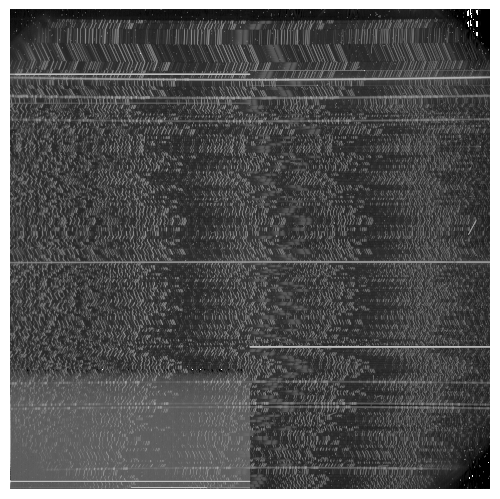

In [ ]:
norm = ImageNormalize(full, vmin=vmin, vmax=vmax)
fig = plt.figure(frameon=False)
ax = fig.add_axes([0,0,1,1])
plt.axis('off')
plt.imshow(full, cmap='gray', norm=LogNorm())
#plt.savefig('deimos_full_rot.jpg', dpi = 1000)
plt.show()